In [186]:
from qutip import *
from qutip.measurement import measure, measurement_statistics
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [348]:
#parameters
N = 65

In [349]:
#cavity operators
ac = tensor(qeye(2),destroy(N))
xc = (ac+ac.dag())/np.sqrt(2)
pc = 1j*(ac.dag()-ac)/np.sqrt(2)
ic = qeye(N)
cavity = basis(N)

In [350]:
#qubit operators
aq = tensor(destroy(2),qeye(N))
xq = (aq+aq.dag())/np.sqrt(2)
pq = 1j*(aq.dag()-aq)/np.sqrt(2)
hq = (sigmax()+sigmaz())/np.sqrt(2)
iq = qeye(2)
qubit = basis(2)

#controlled gates
cD = tensor(0.5*sigmaz()+0.5*qeye(2),qeye(N))+tensor(-0.5*sigmaz()+0.5*qeye(2),displace(N, np.sqrt(2*np.pi)))

cDsym = tensor(0.5*sigmaz()+0.5*qeye(2),displace(N, -np.sqrt(2*np.pi)))+tensor(-0.5*sigmaz()+0.5*qeye(2),displace(N, np.sqrt(2*np.pi)))


In [351]:
# This function gives the probabilities for each string of 0's and 1's 
# for running the phase estimation protocol M times
# It can give the exact result or an approximation

def get_prob(M, exact = False):
    
    prob_real_exact = []
    prob_real_approx = []
    for k in range(M+1):

        prob_approx = 0
        prob_exact = 0

        for p1 in range(2*k+1):
            for p2 in range(2*(M-k)+1):
                prob_exact+=math.comb(2*k,p1)*math.comb(2*(M-k),p2)*( (-1)**(M-k+p2) )*np.exp(-np.pi*(p1+p2-M)**2)

                if p1+p2 == M: # this is the approximation for big alpha
                    prob_approx+=math.comb(2*k,p1)*math.comb(2*(M-k),p2)*( (-1)**(M-k+p2) )

        #Probability is multiplied by multiplicity
        prob_real_exact.append(math.comb(M,k)*prob_exact/2**(2*M))
        prob_real_approx.append(math.comb(M,k)*prob_approx/2**(2*M))
    
    if exact:
        return prob_real_exact
    return prob_real_approx

In [405]:
# qpe algorithm

# This algorithm automatically repeats the protocol using the built-in qutip measure function


def qpe(psi0, N, rep = 1, theta = 0):
    
    phase1 = qdiags([1,np.exp(1j*theta)], offsets=0)    
    phase2 = qdiags([1,np.exp(1j*(theta+np.pi/2))], offsets=0)
    projq = [tensor(ket2dm(basis(2,0)), qeye(N)), tensor(ket2dm(basis(2,1)), qeye(N))]
    
    measures1 = []
    measures2 = []
    fct1 = []
    psi = psi0
    
    for i in range(rep):
        #set qubit to ground state
        if psi.ptrace(0)!= ket2dm(basis(2)):
            psi = tensor(sigmax(),ic)*psi
        
        psi = tensor(hq,ic)*psi
        psi = tensor(iq,displace(N, -np.sqrt(np.pi/2)))*psi
        psi = cD*psi
        
        #measure cos for half the rounds and sin in half the rounds
        if i<rep/2:
            psi1 = tensor(phase1,ic)*psi
        else:
            psi = tensor(phase2,ic)*psi
        
        psi = tensor(hq,ic)*psi
        
        m, psi = measure(psi, projq)
        
        # put measures for cos and sin in different 
        if i<rep/2:
            measures1.append(m)
        else:
            measures2.append(m)
        
        fct1.append(psi)        
    
    return measures1, measures2, fct1

In [398]:
# qpe algorithm

# This function does not repeat the phase estimation protocol. It only runs once and does not measure the system.
# It returns both states and their probability.
def qpe1(psi0, N, theta = 0):
    
    phase = qdiags([1,np.exp(1j*theta)], offsets=0)    
    projq = [tensor(ket2dm(basis(2,0)), qeye(N)), tensor(ket2dm(basis(2,1)), qeye(N))]
    
    psi = tensor(hq,ic)*psi0
    psi = tensor(iq,displace(N, -np.sqrt(np.pi/2)))*psi
    psi = cD*psi
    psi = tensor(phase,ic)*psi
    psi = tensor(hq,ic)*psi
    
    return measurement_statistics(psi, projq)

# This function repeats the previous qpe using an rng.
# It returns a list of each state measured, their probabilities and their eigenvalue.
def qpe_rep_random(psi0, rep):
    psi = psi0
    state_list = []
    prob_list = []
    measure_list = []
    for i in range(rep):
        if psi.ptrace(0) != ket2dm(basis(2)): #if qubit not in state |0>
            psi = tensor(sigmax(), ic)*psi
        
        state,p = qpe1(psi,N)
        rand = random.choices([0,1], weights = p)
        psi = state[rand[0]]
        state_list.append(psi)
        prob_list.append(p[rand[0]])
        measure_list.append(rand[0])
    
    return state_list,prob_list, measure_list

In [388]:
#initial function
psi0 = tensor(qubit,cavity)

#angle
theta = 0

#number of reps
reps = int(np.floor(np.sqrt(N)))
print(reps)

8


In [406]:
#Statistical analysis for qpe_rep_random

m = 100
M=2
count0 = []
count1 = []
for i in range(m):

    states, probs, measures = qpe_rep_random(psi0,M)
    count0.append(measures.count(0))
    count1.append(measures.count(1))



(array([39.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0., 31.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

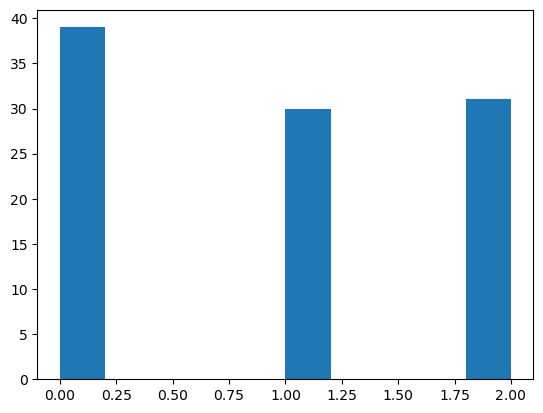

In [408]:
total_nb0 = [count0.count(i) for i in range(M+1)]
total_nb1 = [count1.count(i) for i in range(M+1)]

prob_nb0 = [i/m for i in total_nb0]
prob_nb1 = [i/m for i in total_nb1]
plt.hist(count0)

In [409]:
prob_nb0

[0.39, 0.3, 0.31]

In [413]:
#Statistical analysis for qpe function

m = 1000
M=2
nb0_real = []
nb0_img = []
for i in range(m):

    m1,m2,psi = qpe(psi0,N,rep = 2*M)
    nb0_real.append(m1.count(0))
    #nb0_img.append(m2.count(0))
   

(array([363.,   0.,   0.,   0.,   0., 249.,   0.,   0.,   0., 388.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

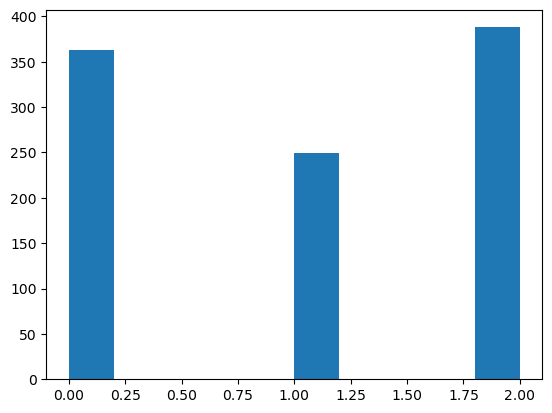

In [414]:
total_nb0 = [nb0_real.count(i) for i in range(M+1)]
#total_nb1 = [count1.count(i) for i in range(M+1)]

prob0 = [i/m for i in total_nb0]
prob1 = [i/m for i in total_nb1]
plt.hist(nb0_real)

In [415]:
prob0

[0.363, 0.249, 0.388]

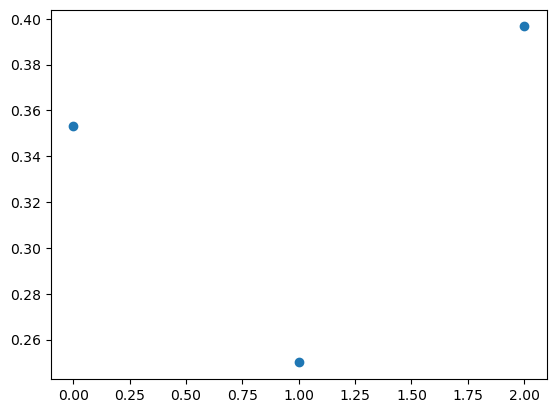

In [365]:
plt.scatter([i for i in range(M+1)], prob_real_exact)

In [366]:
prob_real_approx

[0.375, 0.25, 0.375]

In [367]:
prob_real_exact

[0.3533934767859084, 0.24999912816441094, 0.3966073950496807]

In [394]:
test = tensor(basis(2),basis(N))

In [396]:
test.ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]